In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


result_filename = "124515_results.json"
notebook_dir = os.path.abspath("")

file_path = os.path.abspath(
    os.path.join(
        notebook_dir,
        "..",
        "results",
        "02062025",
        result_filename,
    )
)


# Load JSON data (as list of dicts)
with open(file_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Data preparation

In [2]:
# Helper function to count contained and total facts
def count_facts(fact_list):
    if not isinstance(fact_list, list):
        return 0, 0
    total = len(fact_list)
    contained = sum(f.get("is_contained", False) for f in fact_list)
    return contained, total


# Apply to dataframe
df["direct_facts_contained"], df["direct_facts_total"] = zip(
    *df["fact_score.direct_facts"].apply(count_facts)
)
df["supporting_facts_contained"], df["supporting_facts_total"] = zip(
    *df["fact_score.supporting_facts"].apply(count_facts)
)

# Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         9 non-null      object 
 1   question                                   9 non-null      object 
 2   answer                                     9 non-null      object 
 3   product                                    9 non-null      object 
 4   category                                   9 non-null      object 
 5   persona                                    9 non-null      object 
 6   activity                                   9 non-null      object 
 7   country                                    9 non-null      object 
 8   facts                                      9 non-null      object 
 9   bert_score                                 9 non-null      float64
 10  agent_judge_outcome           

In [4]:
df

,id,question,answer,product,category,persona,activity,country,facts,bert_score,...,agent_judge_tokens_consumed.input_tokens,agent_judge_tokens_consumed.output_tokens,agent_judge_tokens_consumed.total_tokens,tokens_consumed.input_tokens,tokens_consumed.output_tokens,tokens_consumed.total_tokens,direct_facts_contained,direct_facts_total,supporting_facts_contained,supporting_facts_total
0,EA-1,How can I attach additional files to standard ...,To attach additional files to the standard XML...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,Cross,[{'fact': 'You can attach additional files to ...,0.182798,...,4646,3,4649,9488,2602,12090,2,3,1,5
1,EA-2,"For a Greece customer in Public Cloud, what ar...",To enhance the generated XML file for a Greece...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,GR,[{'fact': 'To enhance the generated XML for a ...,0.200139,...,17704,3,17707,8280,1564,9844,5,6,0,3
2,EA-3,For a Greece customer invoice process in Publi...,"Yes, you can enhance or extend the generated X...",ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,GR,[{'fact': 'You can enhance or extend the gener...,0.241308,...,6223,3,6226,8916,2193,11109,1,2,0,1
3,EA-4,"As a Public Cloud customer in Spain, can I ext...","Yes, as a Public Cloud customer in Spain, you ...",ERP (only SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,ES,[{'fact': 'A Public Cloud customer in Spain ca...,0.221864,...,14813,1778,16591,6877,791,7668,2,2,1,2
4,EA-5,"As a Public Cloud customer in Italy, can I ext...","Yes, as a Public Cloud customer in Italy, you...",ERP (only SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,IT,[{'fact': 'As a Public Cloud customer in Italy...,0.207809,...,6047,3,6050,15516,2389,17905,2,2,1,3
5,EA-6,"As a Public Cloud customer in Turkey, can I ex...","No. In Public Cloud, eDocument Actions can not...",ERP (only SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,TR,"[{'fact': 'In Public Cloud, eDocument Actions ...",0.117519,...,7864,3,7867,16436,1637,18073,0,2,0,0
6,EA-7,Can I extend an Action in eDocument Cockpit fo...,"No, Actions can not be extended in Public Cloud",ERP (only SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,Cross,[{'fact': 'Actions cannot be extended in Publi...,0.038973,...,7389,3,7392,11457,2221,13678,0,1,0,0
7,EA-8,Can I extend an Action in eDocument Cockpit fo...,"Yes, you can extend an action in the eDocument...",ERP (excluding SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,Cross,[{'fact': 'You can extend an action in the eDo...,0.153957,...,11511,1544,13055,24794,1258,26052,0,2,0,4
8,EA-10,What BAdIs can be used to extend the Manage El...,The BAdIs EDOC_CUSTOM_FIELDS_CLOUD and EDOC_CU...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,Cross,[{'fact': 'The BAdI EDOC_CUSTOM_FIELDS_CLOUD c...,0.304106,...,6972,3,6975,17077,1202,18279,2,2,0,0


# Fact Score per Experiment

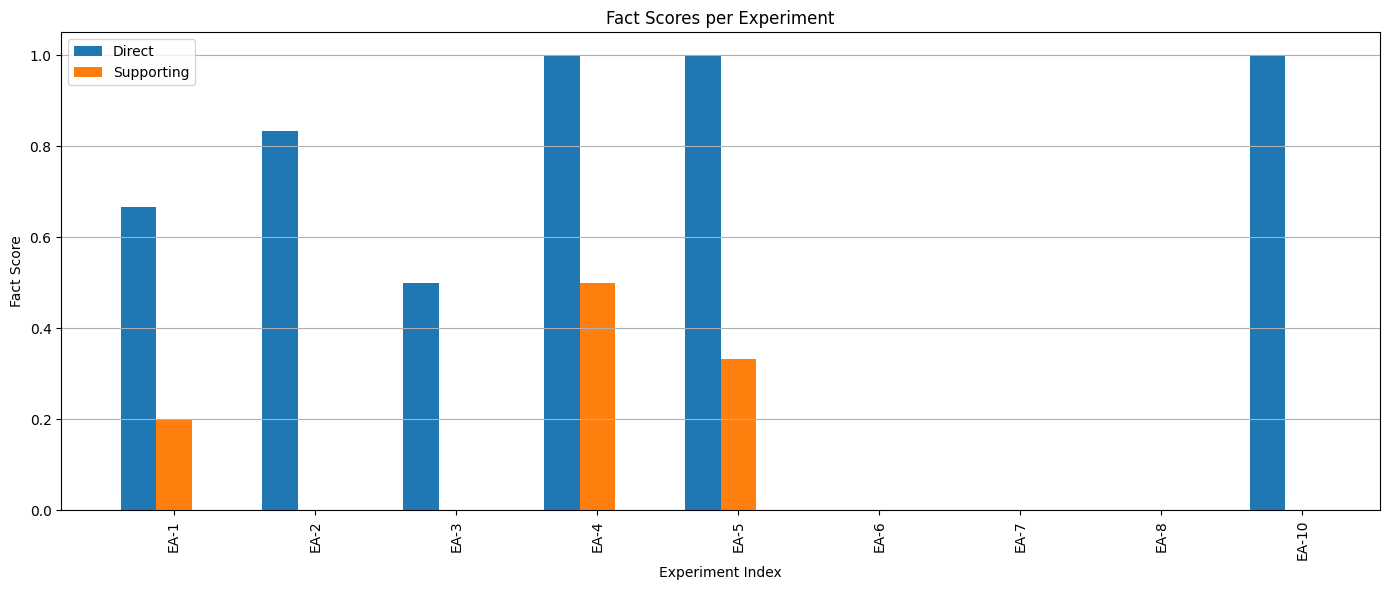

In [5]:
# Set up the indices
indices = np.arange(len(df))
bar_width = 0.25

# Extract fact scores
direct = df["fact_score.direct_fact_score"]
supporting = df["fact_score.supporting_fact_score"]

# Plotting
plt.figure(figsize=(14, 6))
plt.bar(indices - bar_width, direct, width=bar_width, label="Direct")
plt.bar(indices, supporting, width=bar_width, label="Supporting")

# Labels and formatting
plt.xlabel("Experiment Index")
plt.ylabel("Fact Score")
plt.title("Fact Scores per Experiment")
plt.xticks(indices, df["id"], rotation=90)  # assuming `id` is unique per experiment
plt.legend()
plt.tight_layout()
plt.grid(axis="y")

plt.show()

# Correlation Matrix with Direct Fact Score

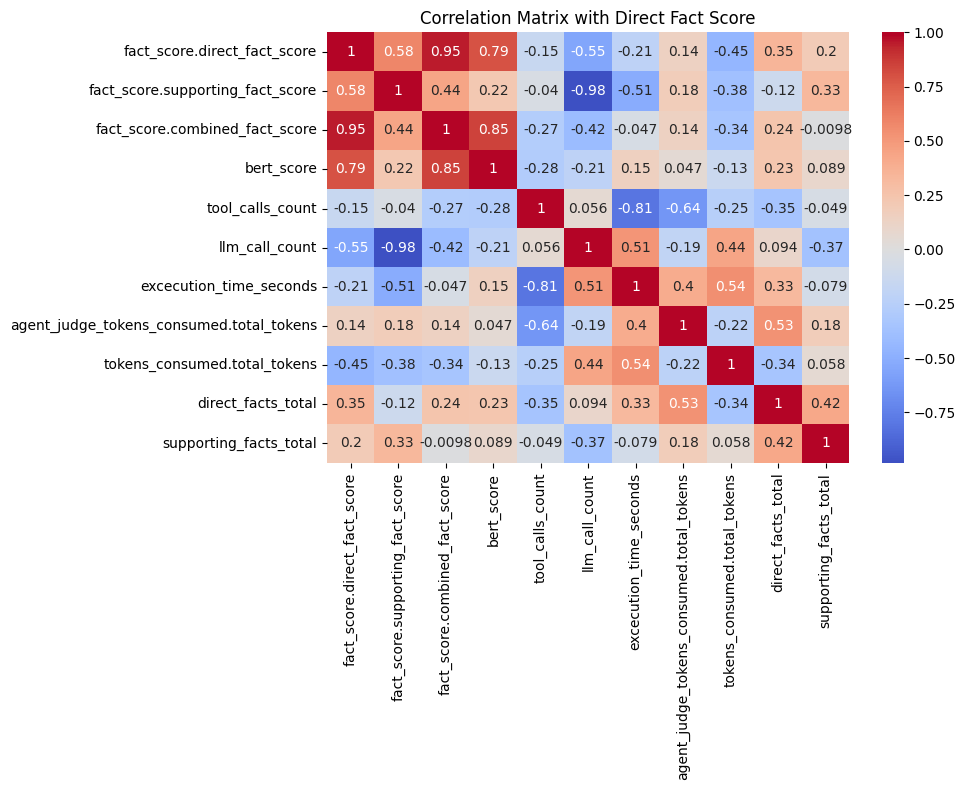

In [6]:
# Select relevant numeric columns
numeric_cols = [
    "fact_score.direct_fact_score",
    "fact_score.supporting_fact_score",
    "fact_score.combined_fact_score",
    "bert_score",
    "tool_calls_count",
    "llm_call_count",
    "excecution_time_seconds",
    "agent_judge_tokens_consumed.total_tokens",
    "tokens_consumed.total_tokens",
    "direct_facts_total",
    "supporting_facts_total",
]

# Compute correlations
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix with Direct Fact Score")
plt.tight_layout()
plt.show()

# Distribution of LLM Judge Outcomes

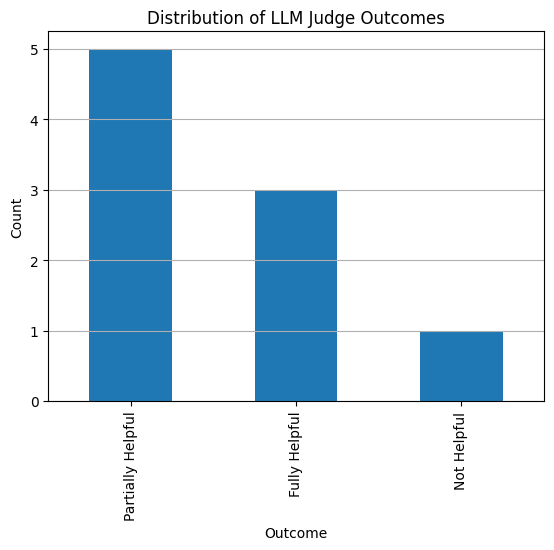

In [8]:
df["agent_judge_outcome"].value_counts().plot(kind="bar")
plt.title("Distribution of LLM Judge Outcomes")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

# BERT Score per Experiment

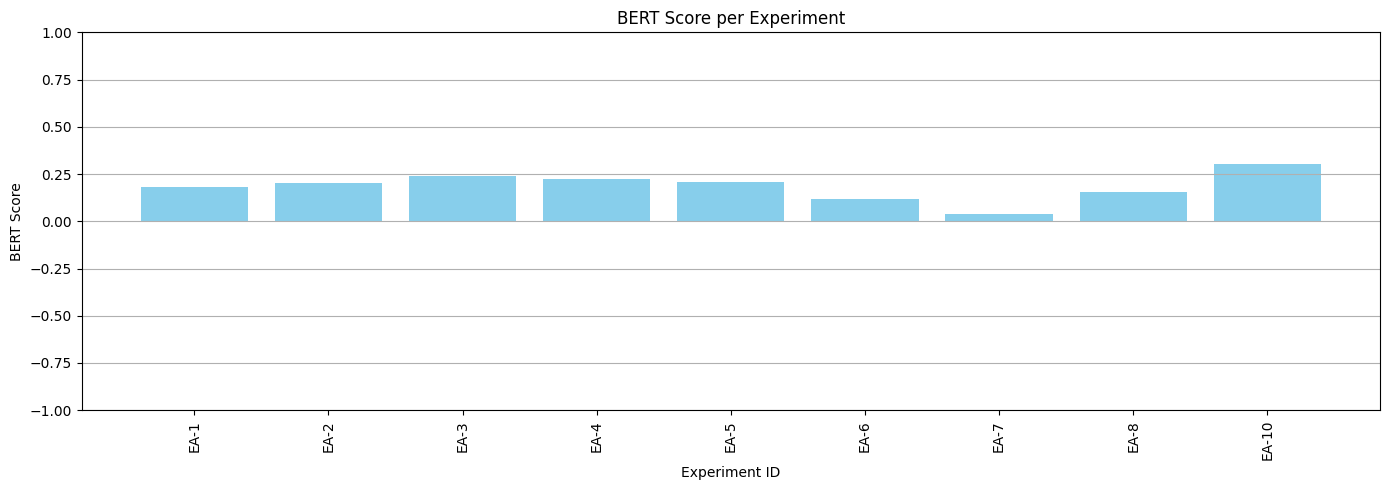

In [9]:
plt.figure(figsize=(14, 5))
plt.bar(df["id"], df["bert_score"], color="skyblue")
plt.xlabel("Experiment ID")
plt.ylabel("BERT Score")
plt.title("BERT Score per Experiment")
plt.ylim(-1, 1)
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Average Direct Fact Score by LLM Judge Outcome

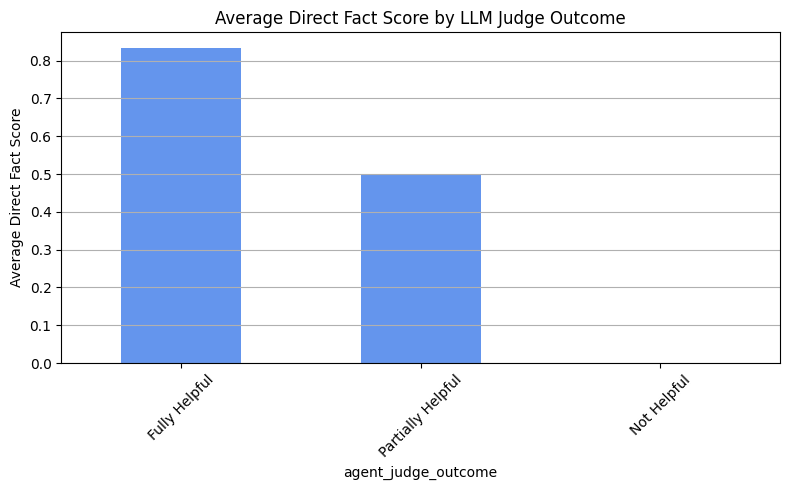

In [10]:
grouped = (
    df.groupby("agent_judge_outcome")["fact_score.direct_fact_score"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 5))
grouped.plot(kind="bar", color="cornflowerblue")
plt.ylabel("Average Direct Fact Score")
plt.title("Average Direct Fact Score by LLM Judge Outcome")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Average Token Consumption by Component

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_69178/675688460.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Agent Judge": [avg_input[0], avg_output[0], avg_total[0]],
/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_69178/675688460.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Agent": [avg_input[1], avg_output[1], avg_total[1]],


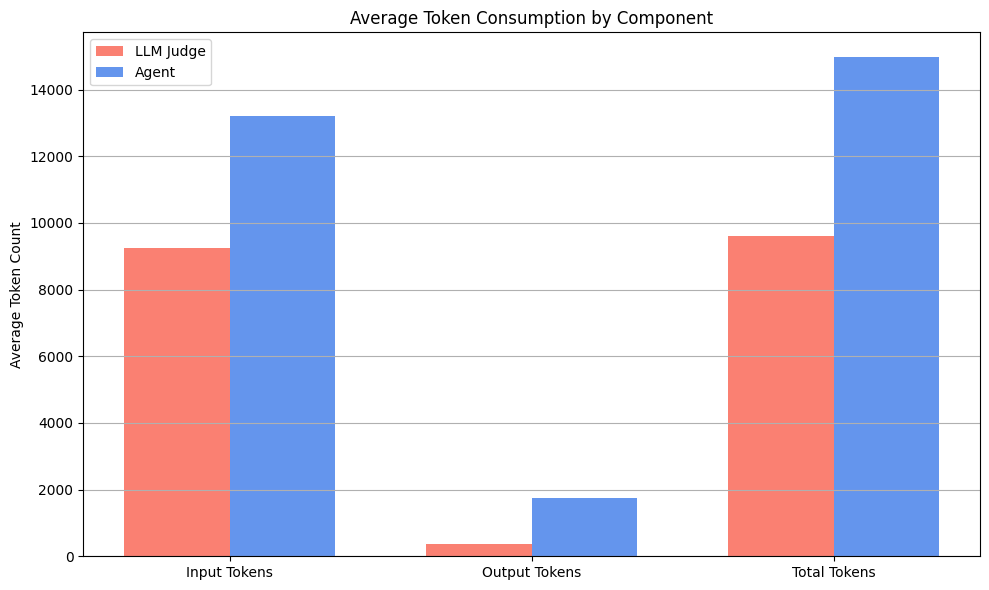

In [12]:
# Calculate average tokens
avg_input = df[
    ["agent_judge_tokens_consumed.input_tokens", "tokens_consumed.input_tokens"]
].mean()
avg_output = df[
    ["agent_judge_tokens_consumed.output_tokens", "tokens_consumed.output_tokens"]
].mean()
avg_total = df[
    ["agent_judge_tokens_consumed.total_tokens", "tokens_consumed.total_tokens"]
].mean()

# Combine into a single DataFrame for plotting
avg_tokens_df = {
    "Agent Judge": [avg_input[0], avg_output[0], avg_total[0]],
    "Agent": [avg_input[1], avg_output[1], avg_total[1]],
}

labels = ["Input Tokens", "Output Tokens", "Total Tokens"]

# Plotting
x = np.arange(len(labels))  # label locations
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(
    x - bar_width / 2,
    avg_tokens_df["Agent Judge"],
    width=bar_width,
    label="LLM Judge",
    color="salmon",
)
plt.bar(
    x + bar_width / 2,
    avg_tokens_df["Agent"],
    width=bar_width,
    label="Agent",
    color="cornflowerblue",
)

plt.xticks(x, labels)
plt.ylabel("Average Token Count")
plt.title("Average Token Consumption by Component")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Fact Contained per Experiment

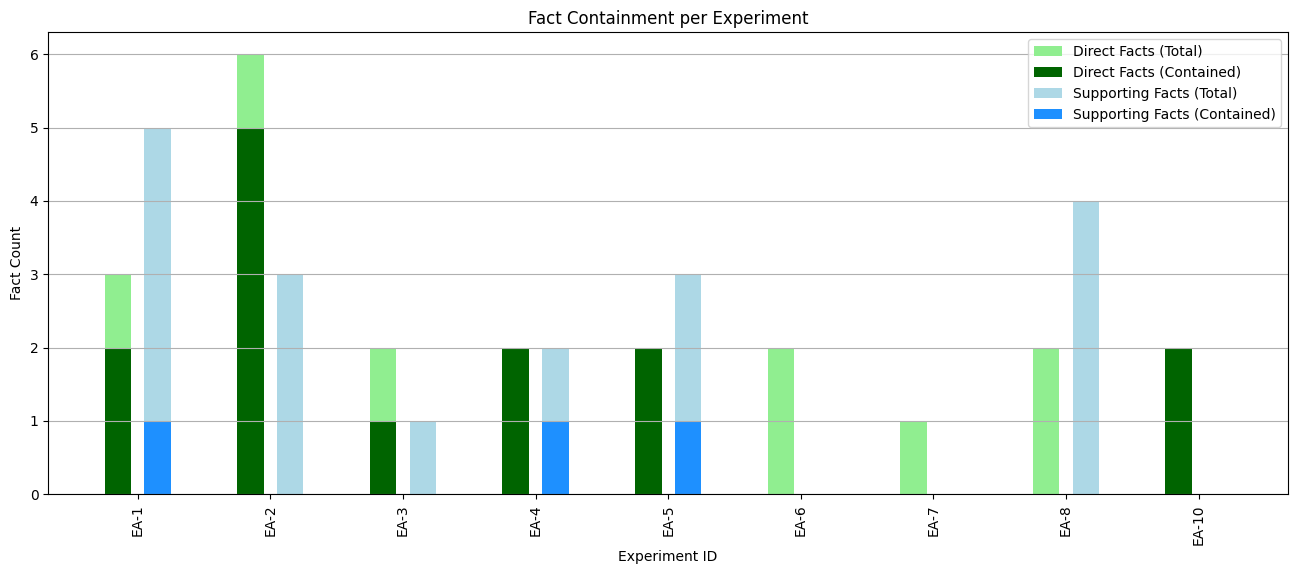

In [15]:
# Setup
num_experiments = len(df)
x = np.arange(num_experiments)

plt.figure(figsize=(16, 6))

# Plot direct facts
plt.bar(
    x - 0.15,
    df["direct_facts_total"],
    width=0.2,
    label="Direct Facts (Total)",
    color="lightgreen",
)
plt.bar(
    x - 0.15,
    df["direct_facts_contained"],
    width=0.2,
    label="Direct Facts (Contained)",
    color="darkgreen",
)

# Plot supporting facts
plt.bar(
    x + 0.15,
    df["supporting_facts_total"],
    width=0.2,
    label="Supporting Facts (Total)",
    color="lightblue",
)
plt.bar(
    x + 0.15,
    df["supporting_facts_contained"],
    width=0.2,
    label="Supporting Facts (Contained)",
    color="dodgerblue",
)

plt.xlabel("Experiment ID")
plt.ylabel("Fact Count")
plt.title("Fact Containment per Experiment")
plt.xticks(x, df["id"], rotation=90)
plt.legend()
plt.grid(axis="y")
plt.show()